In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta  # Import timedelta
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


In [2]:
sentiment_data = pd.read_csv(r"C:\Users\INDHUMATHI\Downloads\sentimental_data_custom.csv") 
sales_data = pd.read_csv(r"C:\Users\INDHUMATHI\Downloads\sales data.csv\Online Sales Data.csv")             

In [3]:
sentiment_data.head()

,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,1,Great experience,Positive,2024-04-16 12:20:00,user_3423,Instagram,#awesome,68,155,India,2024,10,4,17
1,2,Great experience,Positive,2024-08-05 18:59:00,user_1083,LinkedIn,#awesome,98,419,Australia,2024,11,17,8
2,3,Not worth it,Neutral,2024-10-15 10:28:00,user_1228,LinkedIn,#feedback,48,226,India,2024,10,19,22
3,4,Great experience,Neutral,2024-02-07 18:35:00,user_3761,LinkedIn,#feedback,63,155,India,2024,3,28,9
4,5,Not worth it,Positive,2024-09-20 12:44:00,user_1908,LinkedIn,#complaint,63,489,Australia,2024,1,27,11


In [4]:
sentiment_data.isna().count()
sentiment_data.drop_duplicates()


,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,1,Great experience,Positive,2024-04-16 12:20:00,user_3423,Instagram,#awesome,68,155,India,2024,10,4,17
1,2,Great experience,Positive,2024-08-05 18:59:00,user_1083,LinkedIn,#awesome,98,419,Australia,2024,11,17,8
2,3,Not worth it,Neutral,2024-10-15 10:28:00,user_1228,LinkedIn,#feedback,48,226,India,2024,10,19,22
3,4,Great experience,Neutral,2024-02-07 18:35:00,user_3761,LinkedIn,#feedback,63,155,India,2024,3,28,9
4,5,Not worth it,Positive,2024-09-20 12:44:00,user_1908,LinkedIn,#complaint,63,489,Australia,2024,1,27,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Could be better,Negative,2024-05-02 11:53:00,user_7820,LinkedIn,#awesome,48,283,Canada,2024,8,26,4
96,97,Could be better,Positive,2024-03-09 10:17:00,user_7606,Facebook,#awesome,7,469,UK,2024,3,14,16
97,98,Could be better,Negative,2024-05-27 04:29:00,user_2179,Twitter,#feedback,38,317,India,2024,2,1,23
98,99,Not worth it,Neutral,2024-07-18 07:54:00,user_9798,LinkedIn,#complaint,62,296,India,2024,7,2,5


In [5]:
sentiment_data[['Date', 'Time']] = sentiment_data['Timestamp'].str.split(" ", expand=True)


In [6]:
sales_data.head()

,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


In [7]:
sales_data.drop_duplicates()
sales_data.isna().count()


Transaction ID      240
Date                240
Product Category    240
Product Name        240
Units Sold          240
Unit Price          240
Total Revenue       240
Region              240
Payment Method      240
dtype: int64

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sentiment_data["Sentiment_Score"] = sentiment_data["Sentiment"].apply(lambda x: sia.polarity_scores(x)["compound"])
sentiment_data["Date"] = pd.to_datetime(sentiment_data["Date"])
daily_sentiment = sentiment_data.groupby("Date")["Sentiment_Score"].mean().reset_index()

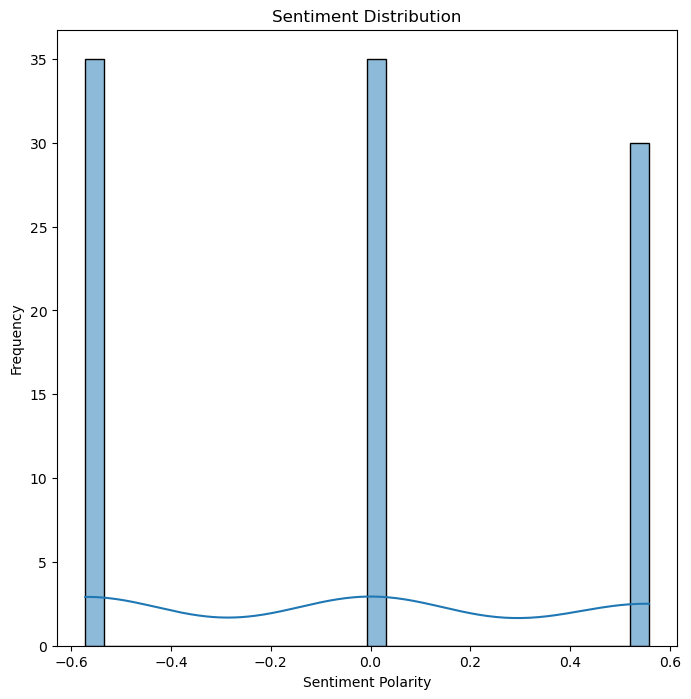

In [9]:
plt.figure(figsize=(8, 8))
sns.histplot(sentiment_data['Sentiment_Score'], kde=True, bins=30)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [10]:
sales_data["Date"] = pd.to_datetime(sales_data["Date"])
sales_data = sales_data.groupby("Date")["Units Sold"].sum().reset_index()

In [11]:
merged_data = pd.merge(sales_data, daily_sentiment, on="Date", how="inner")

In [12]:
merged_data["day_of_week"] = merged_data["Date"].dt.dayofweek
merged_data["month"] = merged_data["Date"].dt.month

In [13]:
X = merged_data[["Sentiment_Score", "day_of_week", "month"]]
y = merged_data["Units Sold"]


In [14]:
merged_data.sample(5)

,Date,Units Sold,Sentiment_Score,day_of_week,month
7,2024-02-15,4,-0.5719,3,2
27,2024-04-16,1,0.5574,1,4
13,2024-03-03,10,0.5574,6,3
10,2024-02-28,2,-0.5719,2,2
11,2024-03-01,3,-0.5719,4,3


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [18]:
y_pred = model.predict(X_test_scaled)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 2.79


In [20]:
future_dates = pd.date_range(start=merged_data["Date"].max() + timedelta(days=1), periods=365)
future_sentiments = np.random.uniform(-0.1, 0.1, len(future_dates))  # Simulate sentiment trends
future_data = pd.DataFrame({
    "Date": future_dates,
    "Sentiment_Score": future_sentiments,
    "day_of_week": future_dates.dayofweek,
    "month": future_dates.month
})


In [21]:
future_data_scaled = scaler.transform(future_data[["Sentiment_Score", "day_of_week", "month"]])
future_sales = model.predict(future_data_scaled)
future_data["predicted_sales"] = future_sales


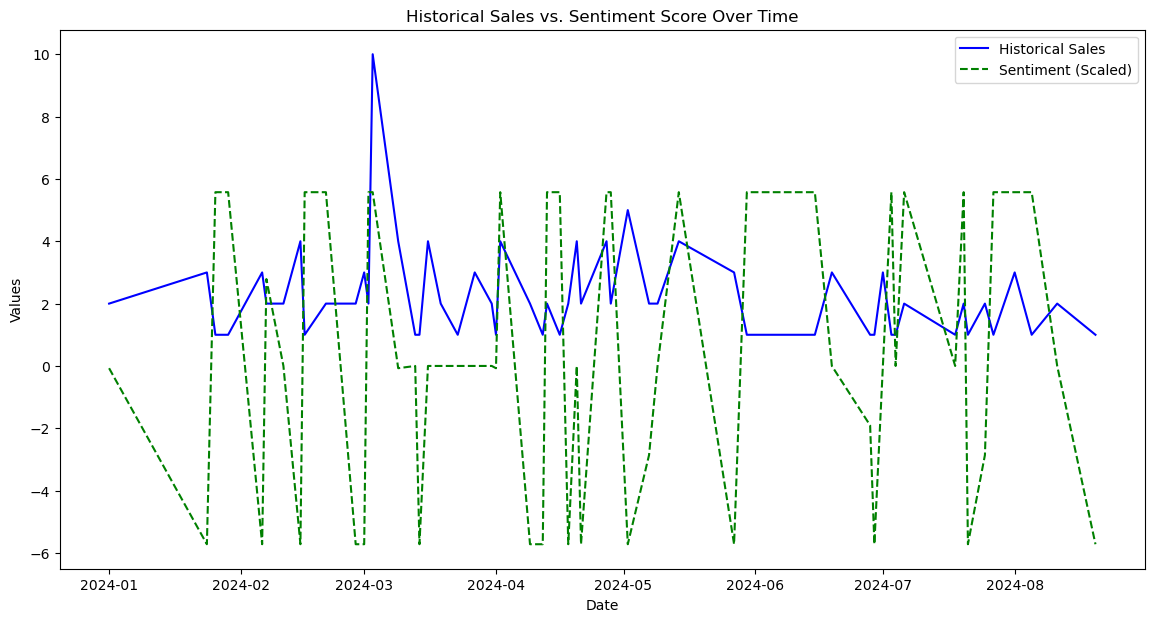

In [22]:
# 1. Historical Sales and Sentiment
plt.figure(figsize=(14, 7))
plt.plot(merged_data["Date"], merged_data["Units Sold"], label="Historical Sales", color="blue")
plt.plot(merged_data["Date"], merged_data["Sentiment_Score"] * merged_data["Units Sold"].max(), 
         label="Sentiment (Scaled)", color="green", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Historical Sales vs. Sentiment Score Over Time")
plt.legend()
plt.show()

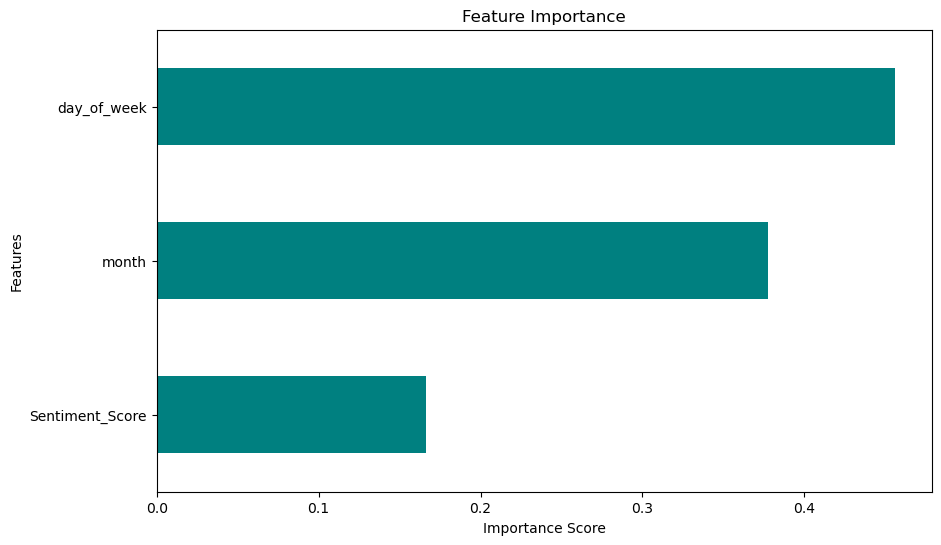

In [23]:
# 2. Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

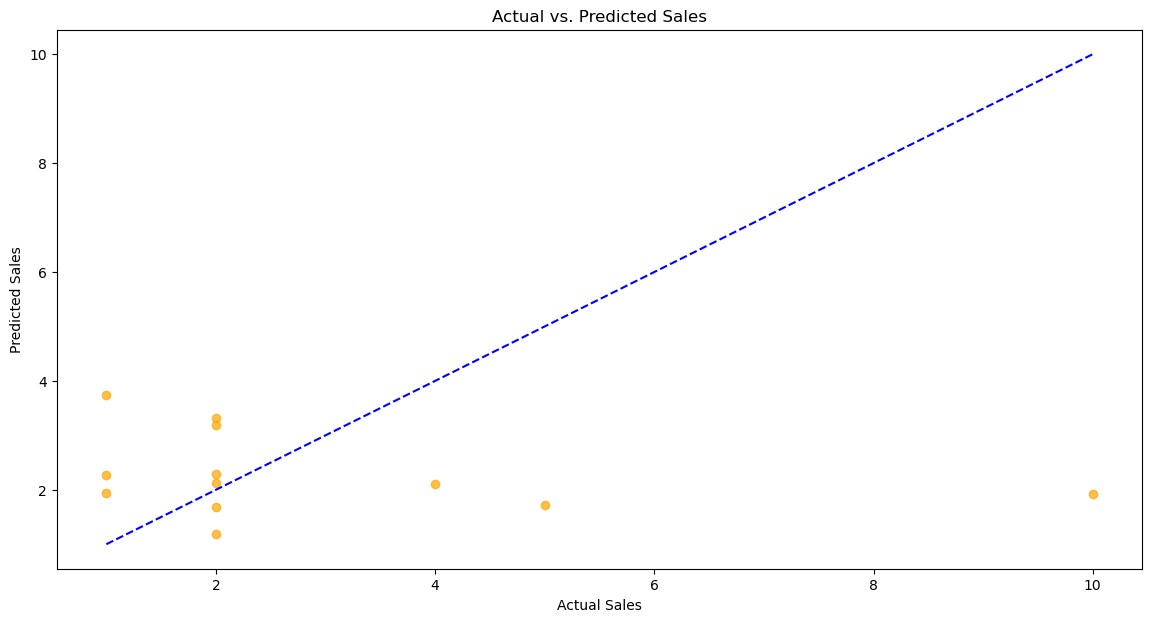

In [24]:
# 3. Actual vs. Predicted Sales (Test Set)
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_pred, alpha=0.7, color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='blue')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales")
plt.show()

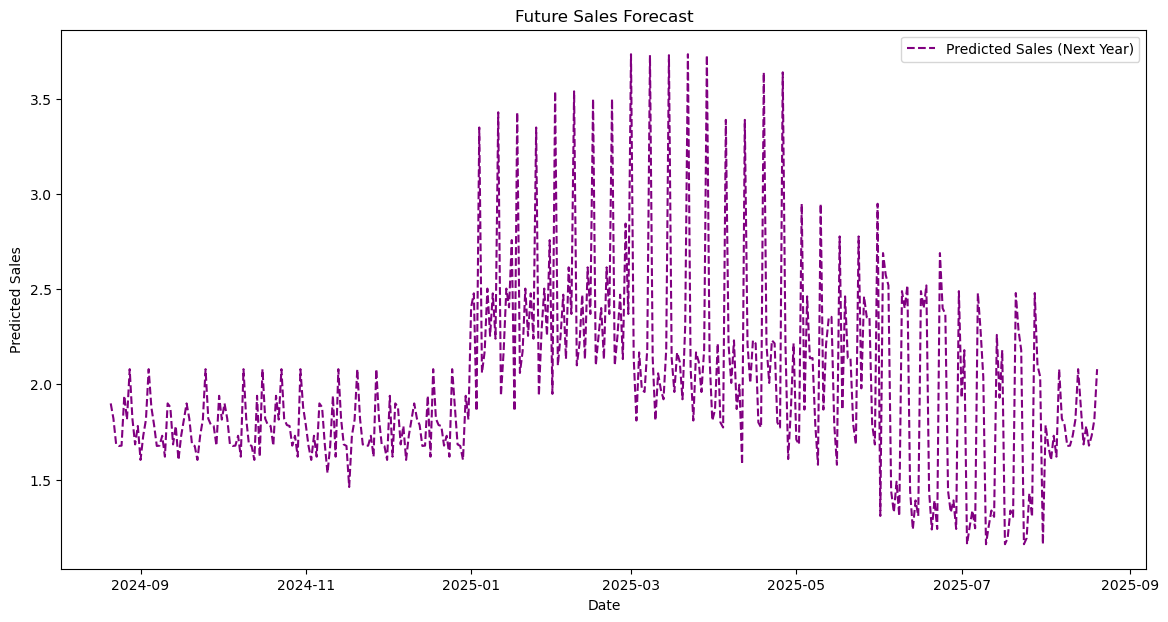

In [25]:
# 4. Future Sales Prediction
plt.figure(figsize=(14, 7))
plt.plot(future_data["Date"], future_data["predicted_sales"], label="Predicted Sales (Next Year)", color="purple", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.title("Future Sales Forecast")
plt.legend()
plt.show()

In [26]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


### I've implemented the real-time dashboard code into this  project. This dashboard generates simulated data for sentiment and sales, updates every 5 seconds, and displays interactive visualizations.

In [27]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import random
import time
import threading

# Simulated data generation
def generate_fake_data(file):
    sentiments = ["positive", "neutral", "negative"]
    products = ["Product A", "Product B", "Product C"]
    
    while True:
        new_data = {
            "timestamp": pd.Timestamp.now(),
            "sentiment": random.choice(sentiments),
            "sales": random.randint(50, 500),
            "product": random.choice(products),
        }
        df = pd.DataFrame([new_data])
        df.to_csv(file, mode='a', header=False, index=False)
        print(f"New data added: {new_data}")
        time.sleep(5)  # Add new data every 5 seconds

# Initialize the CSV file with headers if it doesn't exist
file_name = "real_time_data.csv"
try:
    pd.read_csv(file_name)
except FileNotFoundError:
    initial_df = pd.DataFrame(columns=["timestamp", "sentiment", "sales", "product"])
    initial_df.to_csv(file_name, index=False)

# Start data generation in a separate thread
data_thread = threading.Thread(target=generate_fake_data, args=(file_name,), daemon=True)
data_thread.start()

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
def layout():
    return html.Div([
        html.H1("Real-Time Sentiment and Sales Dashboard"),
        dcc.Interval(id='interval-component', interval=5000, n_intervals=0),  # Update every 5 seconds
        dcc.Graph(id='sentiment-graph'),
        dcc.Graph(id='sales-graph'),
    ])

app.layout = layout()

# Callback for updating graphs
@app.callback(
    [Output('sentiment-graph', 'figure'), Output('sales-graph', 'figure')],
    [Input('interval-component', 'n_intervals')]
)
def update_graphs(n_intervals):
    # Load the latest data
    try:
        df = pd.read_csv(file_name, parse_dates=['timestamp'])
    except Exception as e:
        print(f"Error reading file: {e}")
        return px.scatter(title="No data"), px.scatter(title="No data")

    # Sentiment distribution
    sentiment_fig = px.pie(df, names='sentiment', title="Sentiment Distribution")

    # Sales over time
    sales_fig = px.line(df, x='timestamp', y='sales', color='product', title="Sales Trends")

    return sentiment_fig, sales_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


New data added: {'timestamp': Timestamp('2024-12-25 16:09:24.383801'), 'sentiment': 'positive', 'sales': 258, 'product': 'Product A'}


In [28]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import time
import threading
import requests

# Real-time data fetching from API
def fetch_real_time_data(file):
    api_url = "https://your-api-endpoint.com/data"  # Replace with your actual API endpoint
    
    while True:
        try:
            response = requests.get(api_url)
            if response.status_code == 200:
                data = response.json()
                new_data = {
                    "timestamp": pd.Timestamp.now(),
                    "sentiment": data["sentiment"],
                    "sales": data["sales"],
                    "product": data["product"],
                }
                df = pd.DataFrame([new_data])
                df.to_csv(file, mode='a', header=False, index=False)
                print(f"New data added: {new_data}")
            else:
                print("Failed to fetch data from API, status code:", response.status_code)
        except Exception as e:
            print(f"Error fetching data: {e}")
        time.sleep(5)  # Fetch new data every 5 seconds

# Initialize the CSV file with headers if it doesn't exist
file_name = "real_time_data.csv"
try:
    pd.read_csv(file_name)
except FileNotFoundError:
    initial_df = pd.DataFrame(columns=["timestamp", "sentiment", "sales", "product"])
    initial_df.to_csv(file_name, index=False)

# Start real-time data fetching in a separate thread
data_thread = threading.Thread(target=fetch_real_time_data, args=(file_name,), daemon=True)
data_thread.start()

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
def layout():
    return html.Div([
        html.H1("Real-Time Sentiment and Sales Dashboard"),
        dcc.Interval(id='interval-component', interval=5000, n_intervals=0),  # Update every 5 seconds
        dcc.Graph(id='sentiment-graph'),
        dcc.Graph(id='sales-graph'),
    ])

app.layout = layout()

# Callback for updating graphs
@app.callback(
    [Output('sentiment-graph', 'figure'), Output('sales-graph', 'figure')],
    [Input('interval-component', 'n_intervals')]
)
def update_graphs(n_intervals):
    # Load the latest data
    try:
        df = pd.read_csv(file_name, parse_dates=['timestamp'])
    except Exception as e:
        print(f"Error reading file: {e}")
        return px.scatter(title="No data"), px.scatter(title="No data")

    # Sentiment distribution
    sentiment_fig = px.pie(df, names='sentiment', title="Sentiment Distribution")

    # Sales over time
    sales_fig = px.line(df, x='timestamp', y='sales', color='product', title="Sales Trends")

    return sentiment_fig, sales_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


Error fetching data: HTTPSConnectionPool(host='your-api-endpoint.com', port=443): Max retries exceeded with url: /data (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001AEBD896330>: Failed to resolve 'your-api-endpoint.com' ([Errno 11001] getaddrinfo failed)"))


New data added: {'timestamp': Timestamp('2024-12-25 16:09:29.395019'), 'sentiment': 'neutral', 'sales': 286, 'product': 'Product C'}
Error fetching data: HTTPSConnectionPool(host='your-api-endpoint.com', port=443): Max retries exceeded with url: /data (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001AEC11D7440>: Failed to resolve 'your-api-endpoint.com' ([Errno 11001] getaddrinfo failed)"))
New data added: {'timestamp': Timestamp('2024-12-25 16:09:34.400216'), 'sentiment': 'negative', 'sales': 190, 'product': 'Product C'}
Error fetching data: HTTPSConnectionPool(host='your-api-endpoint.com', port=443): Max retries exceeded with url: /data (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001AEC11D6630>: Failed to resolve 'your-api-endpoint.com' ([Errno 11001] getaddrinfo failed)"))
New data added: {'timestamp': Timestamp('2024-12-25 16:09:39.402782'), 'sentiment': 'positive', 'sales': 427, 'product': 'Product B'}
Err